### Import

In [1]:
# Import from packages
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

### config.py

In [2]:
# Directory with dataset
directory = '/Users/gian-andreagottini/Documents/Masterarbeit (offline)/statsbomb360-euro2020/events/'

# Filepath to one file in dataset
filepath = directory + '3788742.json'

# List with columns relevant for shots dataframe
ls_shots = ['possession_team', 'shot', 'location']

# Dive radius of gk
dive_radius = 3

In [3]:
# Create dataframe
df_test = pd.read_json(filepath)

# Display dataframe
df_test.head(1)

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,dribble,clearance,ball_recovery,foul_committed,off_camera,goalkeeper,shot,foul_won,injury_stoppage,substitution
0,3b0a96ba-e1a5-40c3-8cd4-3b1b5ddfa344,1,1,2022-05-24,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 776, 'name': 'Denmark'}","{'id': 1, 'name': 'Regular Play'}",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### utils.py

In [4]:
# Create datafram including all json files
def create_dataframe(directory):
    
    # Create empty lists
    ls_possession_team = []
    ls_type = []
    ls_shot = []
    ls_location = []

    # Iterate over all files in directory
    for filename in os.listdir(directory):

        # Save current filepath
        filepath = os.path.join(directory, filename)
        # Check if current file has json ending
        if filename.split('.')[1] == 'json':

            # Create dataframe from current json file
            df_file = pd.read_json(filepath)
    
            # Add columns as lists to existing lists
            ls_possession_team.extend(df_file['possession_team'].tolist())
            ls_type.extend(df_file['type'].tolist())
            ls_shot.extend(df_file['shot'].tolist())
            ls_location.extend(df_file['location'].tolist())

    # Create empty dataframe and add lists to dataframe
    df = pd.DataFrame()
    df['possession_team'] = ls_possession_team
    df['type'] = ls_type
    df['shot'] = ls_shot
    df['location'] = ls_location

    # Return dataframe
    return df

# Apply method and display dataframe
df_all = create_dataframe(directory)
print('Number of rows:', len(df_all))
df_all.head(1)

Number of rows: 192686


,possession_team,type,shot,location
0,"{'id': 776, 'name': 'Denmark'}","{'id': 35, 'name': 'Starting XI'}",NaN,NaN


In [5]:
# Create dataframe including all events from one specific type
def filter_event(df, ls):

    # Create event dataframe
    df = df[ls].dropna().reset_index(drop = True)
    
    # Unzip location to coordinates
    df['x_loc'], df['y_loc'] = zip(*df['location'])

    # Return event dataframe
    return df

# Apply method and display dataframe
df_filter_shots = filter_event(df_all, ls_shots)
print('Number of rows:', len(df_filter_shots))
df_filter_shots.head(1)

Number of rows: 1289


,possession_team,shot,location,x_loc,y_loc
0,"{'id': 776, 'name': 'Denmark'}","{'statsbomb_xg': 0.05932782, 'end_location': [...","[97.7, 33.3]",97.7,33.3


In [6]:
# Create shots dataframe with additional data
def complete_shots(df):
    
    # Create shots dataframe
    df = filter_event(df, ls_shots)

    # Create empty lists
    ls_possession_team = []
    ls_shot = []
    ls_location = []
    ls_x_loc = []
    ls_y_loc = []
    ls_outcome = []
    ls_x_gk = []
    ls_y_gk = []
    ls_players = []

    # Iterate over all rows in dataframe
    for j in range (0, len(df)):
        
        # Check if current row has freeze_frame information
        if 'freeze_frame' in df.iloc[j]['shot']:
            
            # Create and reset nested players list
            ls_players_nested = []
            
            # Append values from existing dataframe to lists
            ls_possession_team.append(df.iloc[j]['possession_team'])
            ls_shot.append(df.iloc[j]['shot'])
            ls_location.append(df.iloc[j]['location'])
            ls_x_loc.append(df.iloc[j]['x_loc'])
            ls_y_loc.append(df.iloc[j]['y_loc'])
            
            # Append nested outcome values to list
            ls_outcome.append(df.iloc[j]['shot']['outcome']['name'])
            
            # Save current freeze_frame
            shot = df.iloc[j]['shot']['freeze_frame']
            # Iterate over all players in one freeze_frame
            for i in range (0, len(shot)):
                # Append gk coordinates to lists
                if shot[i]['position']['name'] == 'Goalkeeper' and shot[i]['teammate'] == False:
                    ls_x_gk.append(shot[i]['location'][0])
                    ls_y_gk.append(shot[i]['location'][1])
                # Append other player locations to lists
                else:
                    ls_players_nested.append(shot[i]['location'])
            # Add list or empty string to list
            if len(ls_players_nested) > 0:
                ls_players.append(ls_players_nested)
            else:
                ls_players.append('')
    
    # Add lists to dataframe
    df = pd.DataFrame()
    df['possession_team'] = ls_possession_team
    df['shot'] = ls_shot
    df['outcome'] = ls_outcome
    df['location'] = ls_location
    df['x_loc'] = ls_x_loc
    df['y_loc'] = ls_y_loc
    df['x_gk'] = ls_x_gk
    df['y_gk'] = ls_y_gk
    df['players'] = ls_players
    
    # Return complete shots dataframe
    return df

# Apply method and display dataframe
df_complete_shots = complete_shots(df_all)
print('Number of rows:', len(df_complete_shots))
df_complete_shots.head(1)

Number of rows: 1247


,possession_team,shot,outcome,location,x_loc,y_loc,x_gk,y_gk,players
0,"{'id': 776, 'name': 'Denmark'}","{'statsbomb_xg': 0.05932782, 'end_location': [...",Saved,"[97.7, 33.3]",97.7,33.3,119.2,38.1,"[[86.7, 21.4], [91.1, 43.6], [102.6, 33.2], [9..."


In [7]:
# Create shots dataframe with data about players in shot polygon
def polygon_players(df):
    
    # Create complete shots dataframe and exclude shots without other player locations
    df = complete_shots(df).where(df_complete_shots['players'] != '').dropna().reset_index(drop = True)
    
    # Create empty list
    ls_players = []
        
    # Iterate over all rows in dataframe
    for j in range(0, len(df)):
        # Create and reset nested players list
        ls_players_nested = []
        # Iterate over all players in one shot
        for i in range (0, len(df.iloc[j]['players'])):
            # Add points inside polygon to list
            point = Point(df.iloc[j]['players'][i][0], df.iloc[j]['players'][i][1])
            polygon = Polygon([(df.iloc[j]['x_loc'], df.iloc[j]['y_loc']), (120, 36), (120, 44)])
            if polygon.contains(point) == True:
                ls_players_nested.append(df.iloc[j]['players'][i])
        
        # Add list or empty string to list
        if len(ls_players_nested) > 0:
            ls_players.append(ls_players_nested)
        else:
            ls_players.append('')
    
    # Add list to dataframe
    df['polygon_players'] = ls_players
    
    # Return dataframe with all players in polygon
    return df

# Apply method and display dataframe
df_polygon_players = polygon_players(df_all)
print('Number of rows:', len(df_polygon_players))
df_polygon_players.head(2)

Number of rows: 1234


,possession_team,shot,outcome,location,x_loc,y_loc,x_gk,y_gk,players,polygon_players
0,"{'id': 776, 'name': 'Denmark'}","{'statsbomb_xg': 0.05932782, 'end_location': [...",Saved,"[97.7, 33.3]",97.7,33.3,119.2,38.1,"[[86.7, 21.4], [91.1, 43.6], [102.6, 33.2], [9...",
1,"{'id': 776, 'name': 'Denmark'}","{'statsbomb_xg': 0.019348519, 'end_location': ...",Off T,"[107.5, 36.9]",107.5,36.9,117.6,39.4,"[[112.2, 39.8], [110.6, 37.6], [108.6, 35.4], ...","[[110.6, 37.6], [111.6, 38.6], [112.2, 38.8], ..."


In [8]:
# Calculate angle between two lines from event location to goalposts
def angle(x, y):
    
    # Calculate slope from event location to goalposts
    m1 = (36-y)/(120-x)
    m2 = (44-y)/(120-x)
    
    # Return absolute value of angle in radians
    return abs((math.atan((m1-m2)/(1+m1*m2))))

# Apply method and display value
print('Angle:', math.degrees(angle(112, 36)))

Angle: 45.0


In [9]:
# Calculate slope of bisector
def bisector_slope(x, y):
    
    # x, y = origin = event location
    # x_p, y_p = point = lower goalpost location
    # x_r, y_r = rotated point
    
    ang = angle(x, y)/2
    x_p = 120
    y_p = 36
    
    # Rotate a point counterclockwise by a given angle in radians around a given origin
    x_r = x + math.cos(ang) * (x_p - x) - math.sin(ang) * (y_p - y)
    y_r = y + math.sin(ang) * (x_p - x) + math.cos(ang) * (y_p - y)
    
    # Calculate slope from event location to rotated point
    m = (y_r-y)/(x_r-x)
    
    # Return rotated point
    return m

# Apply method and display value
print('Bisector slope:', bisector_slope(112, 36))

Bisector slope: 0.4142135623730952


In [10]:
# Create dataframe with togkp
def get_togkp(df):
    
    # Create polygon players dataframe
    df = polygon_players(df)

    # Create empty list
    ls_x_opt = []
    ls_y_opt = []

    # Iterate over all rows in dataframe
    for i in range(0, len(df)):

        # Define linear equation of bisector
        x_loc = df.iloc[i]['x_loc']
        y_loc = df.iloc[i]['y_loc']
        m_loc = bisector_slope(x_loc, y_loc)
        q_loc = y_loc - m_loc*x_loc

        # If central shot
        if m_loc == 0:
            x_opt = 120
            y_opt = 40
        # If no central shot
        else:
            # Define linear equation perpendicular to bisector
            d1 = math.dist([x_loc, y_loc], [120, 36])
            d2 = math.dist([x_loc, y_loc], [120, 44])
            if d1 < d2:
                y_p = 36
            else:
                y_p = 44
            x_p = 120
            m_p = -(1/m_loc)
            q_p = y_p - m_p*x_p

            # Calculate intersection of two linear equations
            y_opt = (q_loc - q_p*m_loc/m_p)/(1-(m_loc/m_p))
            x_opt = (y_opt-q_p)/m_p

        # If dive radius is not covered
        if math.dist([x_p, y_p], [x_opt, y_opt]) > dive_radius:

            # Bisector angle in radians
            ang = angle(x_loc, y_loc)/2

            # Distance from event location to optimal location to cover dive radius
            distance = (math.cos(ang)*dive_radius)/math.sin(ang)

            # Shift from shot location to optimal location
            x_shift = distance/(math.sqrt(1+m_loc*m_loc))
            y_shift = x_shift*m_loc

            # Optimal location
            x_opt = x_loc + x_shift
            y_opt = y_loc + y_shift
        
        # Add value to list
        ls_x_opt.append(x_opt)
        ls_y_opt.append(y_opt)

    # Add list to dataframe
    df['x_opt'] = ls_x_opt
    df['y_opt'] = ls_y_opt

    # Return togkp dataframe
    return df

# Apply method and display dataframe
df_togkp = get_togkp(df_all)
print('Number of rows:', len(df_togkp))
df_togkp.head(2)

Number of rows: 1234


,possession_team,shot,outcome,location,x_loc,y_loc,x_gk,y_gk,players,polygon_players,x_opt,y_opt
0,"{'id': 776, 'name': 'Denmark'}","{'statsbomb_xg': 0.05932782, 'end_location': [...",Saved,"[97.7, 33.3]",97.7,33.3,119.2,38.1,"[[86.7, 21.4], [91.1, 43.6], [102.6, 33.2], [9...",,115.163019,38.395993
1,"{'id': 776, 'name': 'Denmark'}","{'statsbomb_xg': 0.019348519, 'end_location': ...",Off T,"[107.5, 36.9]",107.5,36.9,117.6,39.4,"[[112.2, 39.8], [110.6, 37.6], [108.6, 35.4], ...","[[110.6, 37.6], [111.6, 38.6], [112.2, 38.8], ...",117.156918,39.083223


In [11]:
# Create dataframe with all impossible togkp locations
df_false = df_togkp.where(df_togkp['x_opt'] > 120).dropna().reset_index(drop = True)

# Display df_fals with old index
df_togkp.where(df_togkp['x_opt'] > 120).dropna()

,possession_team,shot,outcome,location,x_loc,y_loc,x_gk,y_gk,players,polygon_players,x_opt,y_opt
42,"{'id': 941, 'name': 'Netherlands'}","{'one_on_one': True, 'open_goal': True, 'stats...",Wayward,"[119.4, 37.0]",119.4,37.0,117.9,38.2,"[[99.2, 35.3], [111.1, 61.3], [108.2, 52.6], [...",,120.236050,36.270543
141,"{'id': 770, 'name': 'Germany'}","{'open_goal': True, 'statsbomb_xg': 0.76188177...",Goal,"[119.3, 39.7]",119.3,39.7,112.1,31.0,"[[117.4, 29.6], [116.5, 29.5], [114.8, 45.8], ...",,120.610478,36.230592
422,"{'id': 780, 'name': 'Portugal'}","{'open_goal': True, 'statsbomb_xg': 0.8077789,...",Goal,"[118.2, 37.5]",118.2,37.5,120.0,41.2,"[[114.5, 30.8], [115.9, 32.8], [113.5, 37.0], ...",,120.154156,37.261132
442,"{'id': 914, 'name': 'Italy'}","{'open_goal': True, 'statsbomb_xg': 0.89931935...",Goal,"[118.5, 38.2]",118.5,38.2,118.6,35.1,"[[116.5, 38.7], [110.2, 42.6], [116.0, 50.8], ...",,120.571637,36.939454
955,"{'id': 789, 'name': 'Poland'}","{'statsbomb_xg': 0.45937064, 'end_location': [...",Post,"[116.9, 40.5]",116.9,40.5,119.3,39.2,"[[113.4, 46.9], [113.3, 52.0], [110.2, 43.8], ...",,120.558101,39.354299


In [12]:
# Calculate distance between gkp and togkp
def get_distance(df):
    
    # Create togkp dataframe
    df = get_togkp(df)
    
    # Create empty list
    ls_distance = []
    
    # Iterate over all rows
    for i in range(0, len(df)):
        # Save coordinates
        x1 = df.at[i, 'x_opt']
        y1 = df.at[i, 'y_opt']
        x2 = df.at[i, 'x_gk']
        y2 = df.at[i, 'y_gk']
        # Add value to list
        ls_distance.append(math.dist([x1, y1], [x2, y2]))
    
    # Add list to dataframe
    df['distance'] = ls_distance

    # Return distance dataframe
    return df
    
# Apply method and display dataframe
df_distance = get_distance(df_all)
print('Number of rows:', len(df_distance))
df_distance.head(2)

Number of rows: 1234


,possession_team,shot,outcome,location,x_loc,y_loc,x_gk,y_gk,players,polygon_players,x_opt,y_opt,distance
0,"{'id': 776, 'name': 'Denmark'}","{'statsbomb_xg': 0.05932782, 'end_location': [...",Saved,"[97.7, 33.3]",97.7,33.3,119.2,38.1,"[[86.7, 21.4], [91.1, 43.6], [102.6, 33.2], [9...",,115.163019,38.395993,4.047817
1,"{'id': 776, 'name': 'Denmark'}","{'statsbomb_xg': 0.019348519, 'end_location': ...",Off T,"[107.5, 36.9]",107.5,36.9,117.6,39.4,"[[112.2, 39.8], [110.6, 37.6], [108.6, 35.4], ...","[[110.6, 37.6], [111.6, 38.6], [112.2, 38.8], ...",117.156918,39.083223,0.544674


In [13]:
# Plot one shot
def plot_shot(df, row):
    
    # Plot soccer pitch
    pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
    fig, ax = pitch.draw()

    # Player location
    x_loc = df.at[row, 'x_loc']
    y_loc = df.at[row, 'y_loc']
    plt.scatter(x_loc, y_loc, color = 'blue')

    # Goalkeeper location
    x_gk = df.at[row, 'x_gk']
    y_gk = df.at[row, 'y_gk']
    plt.scatter(x_gk, y_gk, color = 'red')
    
    # Other player location
    for i in range(0, len(df_final.iloc[row]['polygon_players'])):
        x_p = df_final.iloc[row]['polygon_players'][i][0]
        y_p = df_final.iloc[row]['polygon_players'][i][1]
        plt.scatter(x_p, y_p, color = 'yellow')

    # TOGKP
    x_opt = df.at[row, 'x_opt']
    y_opt = df.at[row, 'y_opt']
    plt.scatter(x_opt, y_opt, color = 'orange')

    # Line between player location and gp1
    point1 = df.at[row, 'location']
    point2 = [120, 36]

    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]

    plt.plot(x_values, y_values, color = 'black')

    # Line between player location and gp2
    point1 = df.at[row, 'location']
    point2 = [120, 44]

    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]

    plt.plot(x_values, y_values, color = 'black')
    
    """
    # Plot bisector
    point1 = df.at[row, 'location']
    point2 = [x_opt, y_opt]

    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]

    plt.plot(x_values, y_values, color = 'black')
    """
    
    # Scale plot
    plt.axis('scaled')
    plt.xlim([-5, 125])
    plt.ylim([-5, 85])

    # Display plot
    plt.show()
    
    # Display player and gk location
    print('x_loc:', x_loc, 'y_loc:', y_loc)
    print('x_gk:', x_gk, 'y_gk:', y_gk)

In [14]:
def plot_all(df):
    
    # Plot soccer pitch
    pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)
    fig, ax = pitch.draw()
    
    # Plot all shots
    for i in range(0, len(df)):
        # Player location in blue
        x_loc = df.at[i, 'x_loc']
        y_loc = df.at[i, 'y_loc']
        plt.scatter(x_loc, y_loc, color = 'blue')
        
    # Scale plot
    plt.axis('scaled')
    plt.xlim([-5, 125])
    plt.ylim([-5, 85])

    # Display plot
    plt.show()

In [15]:
"""
# Completed shot dataframe to relevant shots dataframe 
def relevant_shots(df):
    
    # Create complete shot dataframe
    df = complete_shots(df)
    
    # Return relevant shots dataframe
    return df.where((df['outcome'] == 'Goal') | (df['outcome'] == 'Saved') | (df['outcome'] == 'Saved To Post')).dropna().reset_index(drop = True)

# Apply method and display dataframe
df_relevant_shots = relevant_shots(df_all)
df_relevant_shots
"""

"\n# Completed shot dataframe to relevant shots dataframe \ndef relevant_shots(df):\n    \n    # Create complete shot dataframe\n    df = complete_shots(df)\n    \n    # Return relevant shots dataframe\n    return df.where((df['outcome'] == 'Goal') | (df['outcome'] == 'Saved') | (df['outcome'] == 'Saved To Post')).dropna().reset_index(drop = True)\n\n# Apply method and display dataframe\ndf_relevant_shots = relevant_shots(df_all)\ndf_relevant_shots\n"

### data.py

In [16]:
# Apply method and display dataframe
df_final = get_distance(df_all)
print('Number of rows:', len(df_final))
df_final.head(2)

Number of rows: 1234


,possession_team,shot,outcome,location,x_loc,y_loc,x_gk,y_gk,players,polygon_players,x_opt,y_opt,distance
0,"{'id': 776, 'name': 'Denmark'}","{'statsbomb_xg': 0.05932782, 'end_location': [...",Saved,"[97.7, 33.3]",97.7,33.3,119.2,38.1,"[[86.7, 21.4], [91.1, 43.6], [102.6, 33.2], [9...",,115.163019,38.395993,4.047817
1,"{'id': 776, 'name': 'Denmark'}","{'statsbomb_xg': 0.019348519, 'end_location': ...",Off T,"[107.5, 36.9]",107.5,36.9,117.6,39.4,"[[112.2, 39.8], [110.6, 37.6], [108.6, 35.4], ...","[[110.6, 37.6], [111.6, 38.6], [112.2, 38.8], ...",117.156918,39.083223,0.544674


In [17]:
# Apply method and display dataframe
df_1v1 = df_final.where(df_final['polygon_players'] == '').dropna()
print('Number of rows:', len(df_1v1))
df_1v1.head(1)

Number of rows: 567


,possession_team,shot,outcome,location,x_loc,y_loc,x_gk,y_gk,players,polygon_players,x_opt,y_opt,distance
0,"{'id': 776, 'name': 'Denmark'}","{'statsbomb_xg': 0.05932782, 'end_location': [...",Saved,"[97.7, 33.3]",97.7,33.3,119.2,38.1,"[[86.7, 21.4], [91.1, 43.6], [102.6, 33.2], [9...",,115.163019,38.395993,4.047817


### plot.py

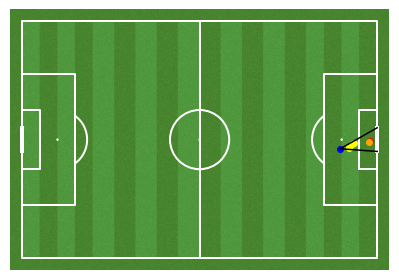

x_loc: 107.5 y_loc: 36.9
x_gk: 117.6 y_gk: 39.4


In [18]:
# Plot one shot
plot_shot(df_final, 1)

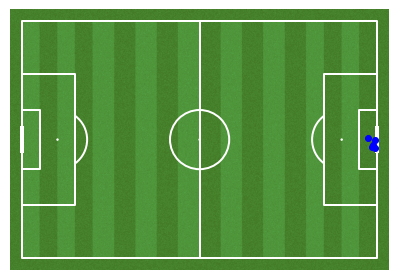

In [19]:
# Plot all shots
plot_all(df_false)

### Testing

In [20]:
def check_deviation(df):
    
    df_saved = df.where(df['outcome'] == 'Saved').dropna().reset_index(drop = True)
    print('Distance for saves:', df_saved['distance'].mean())
    
    df_nogoal = df.where(df['outcome'] != 'Goal').dropna().reset_index(drop = True)
    print('Distance for nogoals:', df_nogoal['distance'].mean())

    df_goal = df.where(df['outcome'] == 'Goal').dropna().reset_index(drop = True)
    print('Distance for goals:', df_goal['distance'].mean())

# Apply method
check_deviation(df_1v1)

Distance for saves: 2.0671576078496265
Distance for nogoals: 2.0738920137782038
Distance for goals: 2.8068248625070193


In [21]:
"""
# Check which dive_radius value gets smallest distance between gkp and togkp

# Initilaize variables
mean_distance = 100
count = 0
dive_radius_copy = dive_radius
dive_radius = 3.3

while count < 3:
    
    # Create dataframe with current dive radius
    df_distance = get_distance(df_all)
    
    # If mean distance is smaller update parameters and reset count to 0
    if df_distance['distance'].mean() < mean_distance:
        mean_distance = df_distance['distance'].mean()
        result = dive_radius
        count = 0
    # If mean distance is larger add 1 to count
    else:
        count = count + 1
    
    # Increase dive radius
    dive_radius = dive_radius + 0.1

# Recreate original dive radius
dive_radius = dive_radius_copy

# Print results
print("Final dive radius:", result)
print("Final mean distance:", mean_distance)
"""

'\n# Check which dive_radius value gets smallest distance between gkp and togkp\n\n# Initilaize variables\nmean_distance = 100\ncount = 0\ndive_radius_copy = dive_radius\ndive_radius = 3.3\n\nwhile count < 3:\n    \n    # Create dataframe with current dive radius\n    df_distance = get_distance(df_all)\n    \n    # If mean distance is smaller update parameters and reset count to 0\n    if df_distance[\'distance\'].mean() < mean_distance:\n        mean_distance = df_distance[\'distance\'].mean()\n        result = dive_radius\n        count = 0\n    # If mean distance is larger add 1 to count\n    else:\n        count = count + 1\n    \n    # Increase dive radius\n    dive_radius = dive_radius + 0.1\n\n# Recreate original dive radius\ndive_radius = dive_radius_copy\n\n# Print results\nprint("Final dive radius:", result)\nprint("Final mean distance:", mean_distance)\n'